In [2]:
from datetime import datetime
import yfinance as yf
import powerlaw as pl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Power Law

### Power law distribution

The probability density function (PDF) of the Power Law Distribution is defined as:

$$
\text{PDF}(x) = L(x) \cdot x^{-(\alpha)} \quad \text{where } x \geq x_{\text{min}}
$$

where:
- $L(x) = \frac{\alpha - 1}{x_{\text{min}}}$ is a normalization constant.
- $\alpha$ is the scaling parameter (also called the tail index).
- $x_{\text{min}}$ is the minimum value for which the power law holds.
- $x$ is the variable of the distribution.

In [2]:
def power_law_pdf (alpha, x, x_min=1):
    pdf_values = np.zeros_like(x)
    pdf_values[x >= x_min] = (alpha - 1) / x_min * (x[x >= x_min] / x_min) ** (-alpha)
    return pdf_values

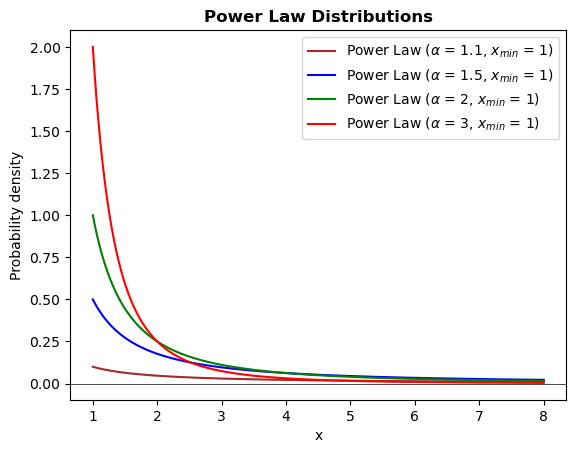

In [3]:
samples = 1000
x_min = 1
x = np.linspace(x_min, 8, samples+1)

alphas = [1.1, 1.5, 2, 3]
colors = ['brown', 'b', 'g', 'r']
for i in range(len(alphas)):
    plt.plot(x, power_law_pdf(alpha=alphas[i], x=x, x_min=x_min), colors[i], linewidth=1.5, \
             label=r'Power Law ($\alpha$ = {}, $x_{{min}}$ = {})'.format(alphas[i], x_min))
plt.title('Power Law Distributions', fontweight = 'bold')
plt.axhline(0,color='black',linewidth=0.5)
plt.legend()
plt.ylabel("Probability density")
plt.xlabel("x")
plt.show()

# Test on statistical metrics

The law of large numbers doesn’t hold for power law distribution. The mean and other metrics won’t converge (unstable behavior) to the theoretical metric with larger samples.

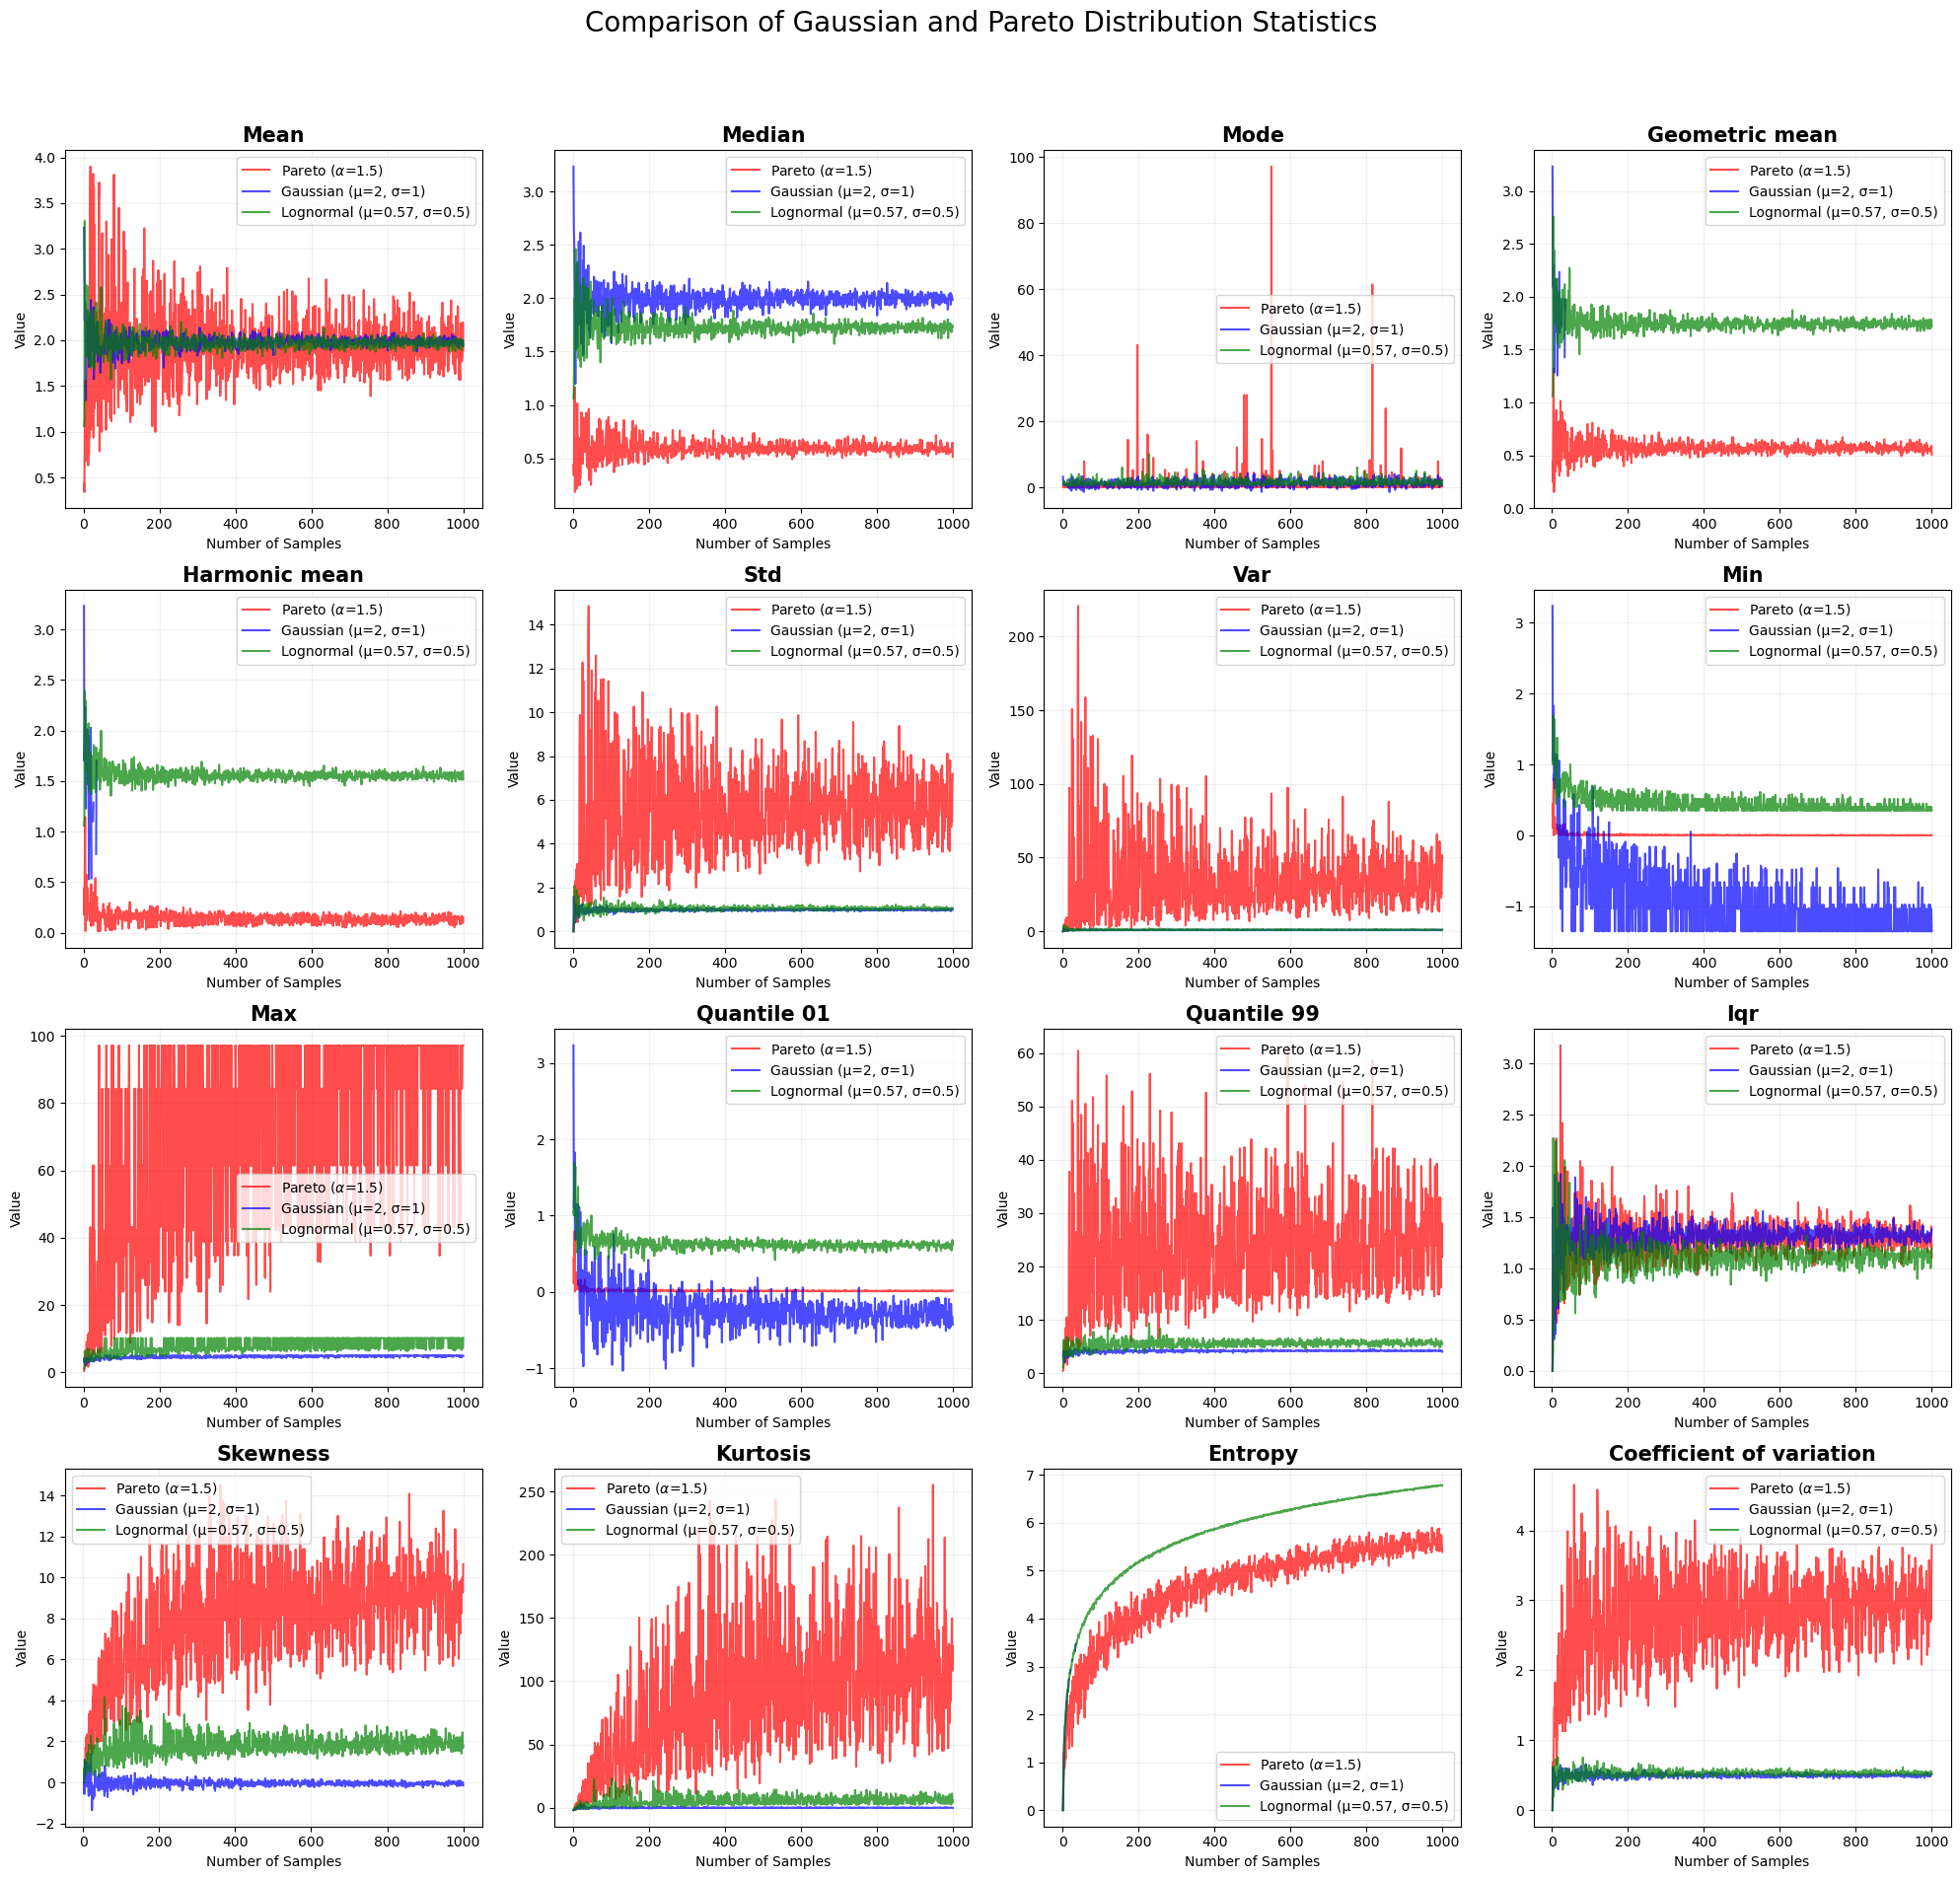

In [4]:
gaussian_mu = 2
gaussian_sigma = 1
lognormal_sigma = 0.5
lognormal_mu = round(np.log(2) - (lognormal_sigma**2 / 2), 2) # the 2 in np.log(2) can be replaced with any target mean
pareto_a = 1.5
pareto_theoretical_mean = ((pareto_a * x_min) / (pareto_a - 1)) - 1 if pareto_a > 1 else np.inf 
# numpy implements a shifted Pareto distribution

x_min = 1
size = 1000

pareto_sample = np.random.pareto(a=pareto_a, size=size) * x_min
gaussian_sample = np.random.normal(loc=gaussian_mu, scale=gaussian_sigma, size=size)
lognormal_sample = np.random.lognormal(mean=lognormal_mu, sigma=lognormal_sigma, size=size)

# Function to calculate statistics
def calculate_statistics(sample, i):
    s = np.random.choice(sample, size=i, replace=True)
    return {
        'mean': np.mean(s),
        'median': np.median(s),
        'mode': stats.mode(s).mode,
        'geometric_mean': stats.gmean(s) if np.all(s > 0) else np.nan,
        'harmonic_mean': stats.hmean(s) if np.all(s > 0) else np.nan,
        'std': np.std(s),
        'var': np.var(s),
        'min': np.min(s),
        'max': np.max(s),
        'quantile_01': np.quantile(s, 0.01),
        'quantile_99': np.quantile(s, 0.99),
        'iqr': stats.iqr(s),
        'skewness': stats.skew(s),
        'kurtosis': stats.kurtosis(s),
        'entropy': stats.entropy(s),
        'coefficient_of_variation': stats.variation(s)
    }

# Create dataframes
sample_sizes = range(1, size + 1)
pareto_df = pd.DataFrame([calculate_statistics(pareto_sample, i) for i in sample_sizes])
gaussian_df = pd.DataFrame([calculate_statistics(gaussian_sample, i) for i in sample_sizes])
lognormal_df = pd.DataFrame([calculate_statistics(lognormal_sample, i) for i in sample_sizes])

# Plotting
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
fig.suptitle('Comparison of Gaussian and Pareto Distribution Statistics', fontsize=20)

for idx, stat in enumerate(pareto_df.columns):
    ax = axes[idx // 4, idx % 4]
    ax.plot(sample_sizes, pareto_df[stat], label=r'Pareto ($\alpha$={})'.format(pareto_a), color='red', alpha=0.7)
    ax.plot(sample_sizes, gaussian_df[stat], label=f'Gaussian (μ={gaussian_mu}, σ={gaussian_sigma})', color='blue', alpha=0.7)
    ax.plot(sample_sizes, lognormal_df[stat], label=f'Lognormal (μ={lognormal_mu}, σ={lognormal_sigma})', color='green', alpha=0.7)
    ax.set_title(stat.capitalize().replace("_"," "), fontweight = 'bold', fontsize=15)
    ax.set_xlabel('Number of Samples')
    ax.set_ylabel('Value')
    ax.legend()
    ax.grid(True, which="both", ls="-", alpha=0.2)

# Remove extra subplots
for idx in range(len(pareto_df.columns), 16):
    fig.delaxes(axes[idx // 4, idx % 4])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Regression

In linear regression, α ≤ 2 → Var (Error) = ∞ → R2 = 0.

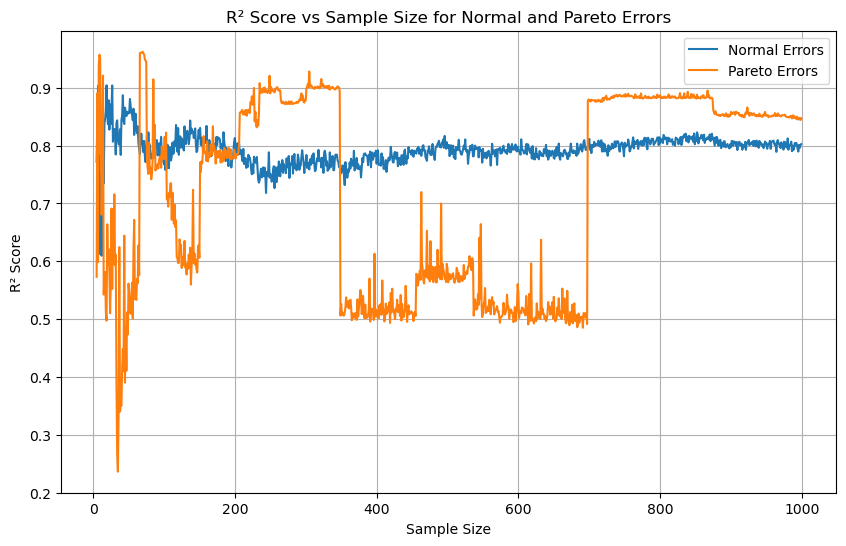

Final R² for Normal Errors: 80.2680 %.
Final R² for Pareto Errors: 84.7314 %.


In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def generate_data(a, b, size, error_type='normal', seed=1):
    if seed is not None:
        np.random.seed(seed)
        
    if error_type == 'normal':
        x = np.random.normal(5, 1, size)
        errors = np.random.normal(5, 1, size)
    elif error_type == 'pareto':
        x = np.random.pareto(2.2, size)
        errors = np.random.pareto(2.2, size)
    
    y = a * x + b + errors
    return x, y

def compute_r2(x, y):
    X = x.reshape(-1, 1)
    model = LinearRegression().fit(X, y)
    return r2_score(y, model.predict(X))

# Parameters
max_size = 1000

sizes = range(5, max_size)
r2_normal = []
r2_pareto = []

for size in sizes:

    x_normal, y_normal = generate_data(2, 1, size, 'normal', 67)
    x_pareto, y_pareto = generate_data(2, 1, size, 'pareto', 67)
    
    r2_normal.append(compute_r2(x_normal, y_normal))
    r2_pareto.append(compute_r2(x_pareto, y_pareto))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(sizes, r2_normal, label='Normal Errors')
plt.plot(sizes, r2_pareto, label='Pareto Errors')
plt.xlabel('Sample Size')
plt.ylabel('R² Score')
plt.title('R² Score vs Sample Size for Normal and Pareto Errors')
plt.legend()
plt.grid(True)
plt.show()

# Print final R² scores
print(f"Final R² for Normal Errors: {r2_normal[-1]*100:.4f} %.")
print(f"Final R² for Pareto Errors: {r2_pareto[-1]*100:.4f} %.")

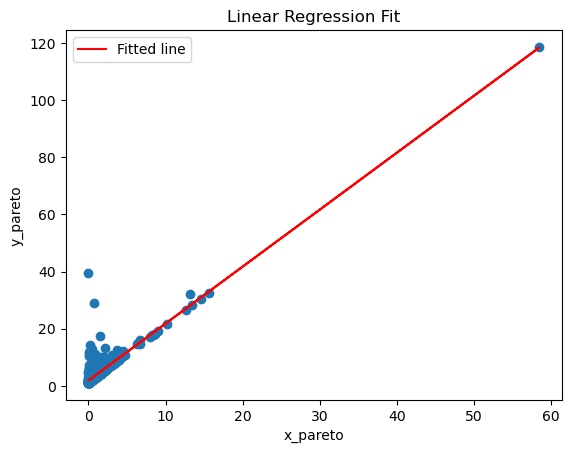

In [33]:
X = x_pareto.reshape(-1, 1)
model = LinearRegression().fit(X, y_pareto)
y_pred = model.predict(X)

plt.scatter(x_pareto, y_pareto)
# Plot the regression line
plt.plot(x_pareto, y_pred, color='red', label='Fitted line')

# Add labels and title
plt.xlabel('x_pareto')
plt.ylabel('y_pareto')
plt.title('Linear Regression Fit')
plt.legend()

# Show plot
plt.show()

### Pareto data

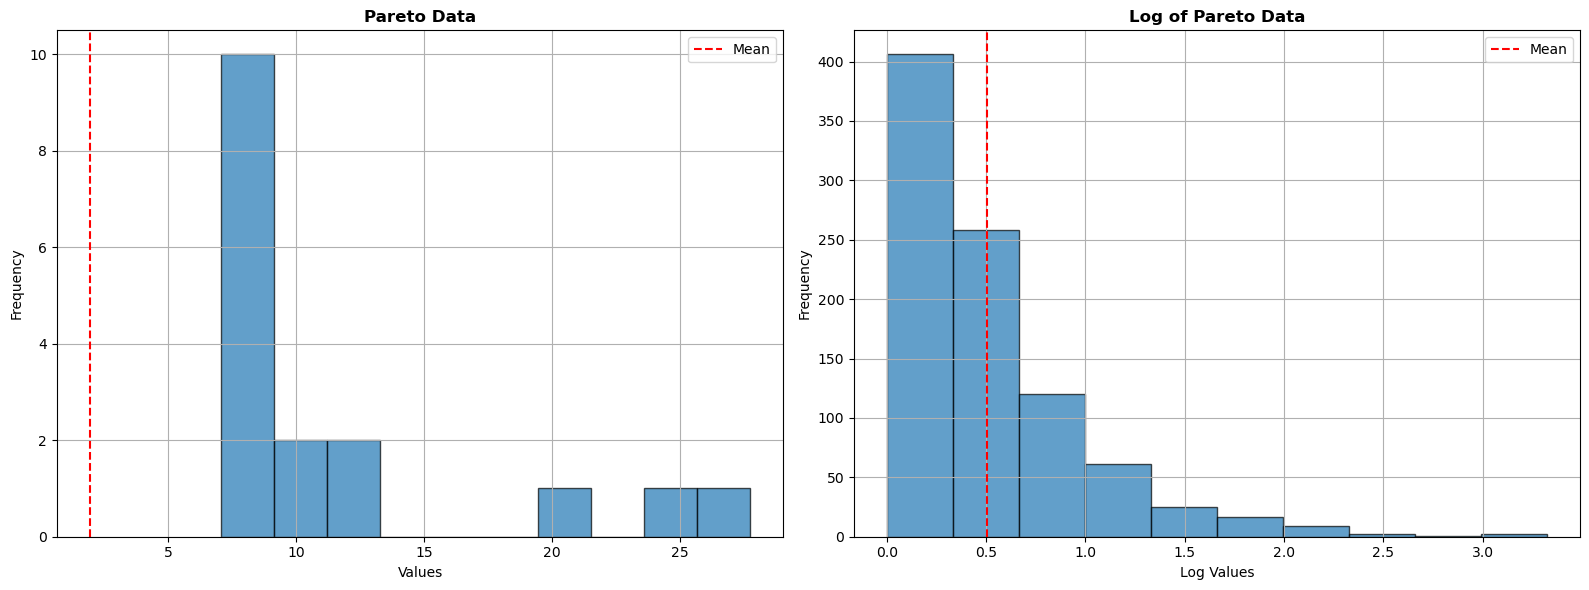

In [7]:
n = 900
alpha = 2
z_min = 1
z = np.linspace(0, n, n+1)
pareto = (np.random.pareto(alpha, len(z)) + 1) * z_min

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Original Pareto plot
ax1.hist(pareto, edgecolor='black', alpha=0.7, range=(pareto[0], pareto.max()))
ax1.set_title('Pareto Data', fontweight='bold')
ax1.set_xlabel('Values')
ax1.set_ylabel('Frequency')
ax1.axvline(x=pareto.mean(), color='r', linestyle='--', label='Mean')
ax1.grid(True)
ax1.legend()

# Log of Pareto plot
log_pareto = np.log(pareto)
ax2.hist(log_pareto, edgecolor='black', alpha=0.7, range=(log_pareto.min(), log_pareto.max()))
ax2.set_title('Log of Pareto Data', fontweight='bold')
ax2.set_xlabel('Log Values')
ax2.set_ylabel('Frequency')
ax2.axvline(x=log_pareto.mean(), color='r', linestyle='--', label='Mean')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

#### Log-Log Approach

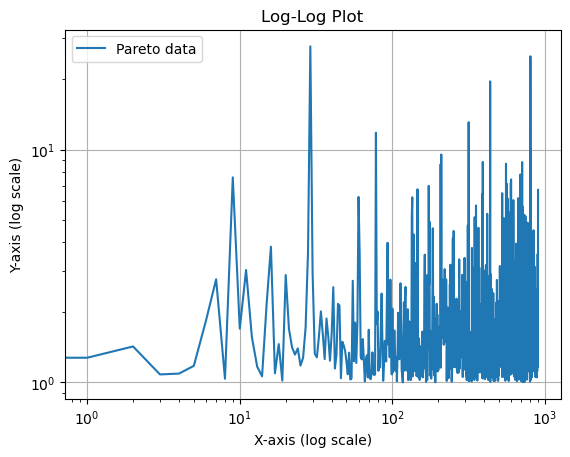

In [8]:
# Create a log-log plot
plt.loglog(z, pareto, label='Pareto data')
plt.title('Log-Log Plot')
plt.xlabel('X-axis (log scale)')
plt.ylabel('Y-axis (log scale)')
plt.legend()
plt.grid(True)
plt.show()

#### Alpha: Tail Index

If α ≤ 1, forget about it. (The lower the α, the fatter the tail)

In [9]:
pareto_results = pl.Fit(pareto)

print("alpha = " + str(pareto_results.power_law.alpha - 1))
print("x_min = " + str(pareto_results.power_law.xmin))
print('p_value = ' + str(sum(pareto_results.Ds > pareto_results.D)/len(pareto_results.Ds)))

Calculating best minimal value for power law fit
alpha = 2.154691931098488
x_min = 1.4009869215351367
p_value = 0.9988888888888889


#### Log normal fit

Log-normal behaves like Power Law for high σ.

In [10]:
print("Log normal fit mean = " + str(pareto_results.lognormal.mu))
print("Log normal fit sdv = " + str(pareto_results.lognormal.sigma))

Log normal fit mean = -332.7832116883094
Log normal fit sdv = 12.449811824452922


Log normal fit is not a good fit because the mean is negative!

#### Taleb's  $\kappa$

Nassim Nicholas Taleb introduced the kappa measure as a way to quantify the fat-tailedness of a distribution. The kappa measure is  more robust to outliers compared to traditional measures like kurtosis, and it's finite for all distributions with a finite mean. The kappa (κ) is defined as:

$$
K(n_0, n) = 2 - \frac{\log n - \log n_0}{\log \frac{M(n)}{M(n_0)}}
$$

**Where**:
- $M(n) \cong M(S_n) = E(|S_n - E(S_n)|)$: Mean absolute deviation
- $S_n = \sum_{i=1}^{n} s_i$: The sum of samples $s_i$ drawn from a distribution.
- $n_0$: number of samples from some distribution.


Taleb suggests the following categorization:
- κ ~ 0: Thin-tailed
- κ ~ 1: Fat-tailed

**Note**: Works for unimodal data with finite mean.

In [11]:
def MAD(sample):
    return np.mean(np.abs(sample - np.mean(sample)))

def generate_random_samples(data, num):
    sample = 0
    for i in range(num):
        sample += np.random.choice(data, size=num, replace=True)
    return sample
    # return np.random.choice(data, size=num, replace=True)

def calculate_kappa(data, n, n0):
    """Calculate Taleb's kappa measure."""
    S_n0 = data # to be corrected
    S_n = generate_random_samples(data, n)
    
    M_n0 = MAD(S_n0)
    M_n = MAD(S_n)
    
    return 2 - ((np.log(n)-np.log(n0))/np.log(M_n/M_n0))

def interpret_kappa(kappa):
    """Interpret the kappa value."""
    if kappa <= 0.3:
        return "Thin-tailed"
    elif kappa >= 0.7:
        return "Fat-tailed"
    else:
        return "Mesokurtic (medium-tailed)"

In [12]:
num = 100
interpret_kappa(calculate_kappa(pareto, num, len(pareto)))

'Fat-tailed'

#### Kurtosis

Kurtosis (breaks down for Power Law with α ≤ 4)

In [13]:
kurtosis = stats.kurtosis(pareto, fisher=False)
print(f"Kurtosis: {kurtosis:.4f}")

Kurtosis: 85.5635


### Log normal data

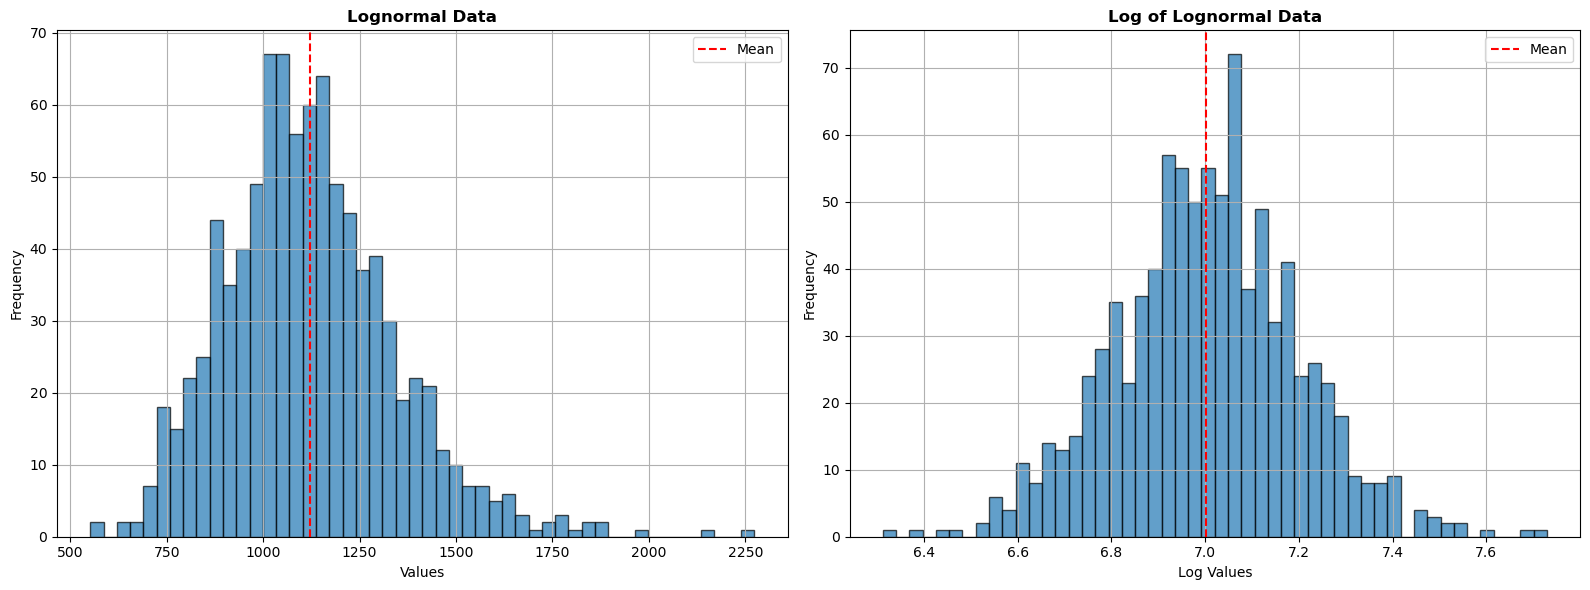

In [14]:
mean = 7
sdv = 0.2
lognormal = np.random.lognormal(mean, sdv, len(z))# * sdv * np.sqrt(2*np.pi)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Original Lognormal plot
ax1.hist(lognormal, bins=50, edgecolor='black', alpha=0.7)
ax1.set_title('Lognormal Data',fontweight='bold')
ax1.set_xlabel('Values')
ax1.set_ylabel('Frequency')
ax1.axvline(x=lognormal.mean(), color='r', linestyle='--', label='Mean')
ax1.grid(True)
ax1.legend()

# Log of Lognormal plot
log_lognormal = np.log(lognormal)
ax2.hist(log_lognormal, bins=50, edgecolor='black', alpha=0.7)
ax2.set_title('Log of Lognormal Data',fontweight='bold')
ax2.set_xlabel('Log Values')
ax2.set_ylabel('Frequency')
ax2.axvline(x=log_lognormal.mean(), color='r', linestyle='--', label='Mean')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

In [15]:
lognormal_results = pl.Fit(lognormal, xmin=lognormal.min())

print("alpha = " + str(lognormal_results.power_law.alpha - 1))
print("x_min = " + str(lognormal_results.power_law.xmin))
print("mean = " + str(lognormal_results.lognormal.mu))
print("sdv = " + str(lognormal_results.lognormal.sigma))

alpha = 1.449557759228358
x_min = 551.23113894769
mean = 7.001847155327966
sdv = 0.19509198271368897


In [16]:
distribution_list = ['exponential', 'stretched_exponential', 'lognormal', 
                     'lognormal_positive', 'truncated_power_law']
R_list = []
    
for distribution in distribution_list:
    R, p = lognormal_results.distribution_compare('power_law', distribution)
    R_list.append(R) # R is the log-likelihood ratio
    print("power_law vs " + distribution + ": R = " + str(np.round(R,3)) + ", p = " + str(np.round(p,3)))

if min(R_list) < 0:
    print(f"\n{distribution_list[R_list.index(min(R_list))].capitalize()} distribution is a better fit than Power law distribution.")
else:
    print("\nPower law distribution is a better fit.")

power_law vs exponential: R = -258.944, p = 0.0
power_law vs stretched_exponential: R = -692.967, p = 0.0
power_law vs lognormal: R = -762.144, p = 0.0
power_law vs lognormal_positive: R = -762.144, p = 0.0


Assuming nested distributions


power_law vs truncated_power_law: R = -176.483, p = 0.0

Lognormal distribution is a better fit than Power law distribution.


# Asset

In [3]:
# Get ticker data
ticker = yf.Ticker('^GSPC')
asset_data = yf.download(ticker.info['symbol'], start='1990-01-01', end='2024-06-01')

[*********************100%%**********************]  1 of 1 completed


## Returns

In [ ]:
# Calculate the percentage change in the stock price (simple return)
asset_data['Return'] = asset_data['Adj Close'].pct_change()

Log returns are undefined for negative or null prices.

This is particularly relevant for:

1. Derivatives and futures that can have negative prices (e.g., oil futures in 2020)
2. Deeply distressed securities approaching zero
3. Certain fixed income instruments trading below par

In [ ]:
if np.any(asset_data['Adj Close']  <= 0):
    valid_mask = (asset_data['Adj Close'].iloc[1:] > 0) & (asset_data['Adj Close'].iloc[:-1] > 0)
    safe_prices = asset_data['Adj Close'].iloc[valid_mask]
    asset_data['Log_Return'] = np.log(safe_prices / safe_prices.shift(1))
else:
    asset_data['Log_Return'] = np.log(asset_data['Adj Close'] / asset_data['Adj Close'].shift(1)) 
asset_data.dropna(inplace=True)

In [ ]:
# Create a candlestick chart
fig = go.Figure(
    data=[
        go.Candlestick(
            x=asset_data.index,
            open=asset_data.iloc[:, 0], 
            high=asset_data.iloc[:, 1],
            low=asset_data.iloc[:, 2], 
            close=asset_data.iloc[:, 3],
            increasing_line_color='green', 
            decreasing_line_color='red',
        )
    ]
)

# Update the layout
fig.update_layout(
    title="Candlestick Chart for {}".format(ticker.info['shortName']),
    xaxis_rangeslider_visible=False, 
    template="plotly_dark",
    yaxis_title=f"{ticker.info['shortName']} price (USD)", 
    xaxis_title="Date"
)

# Show the figure
fig.show()

# Annualized rolling volatility

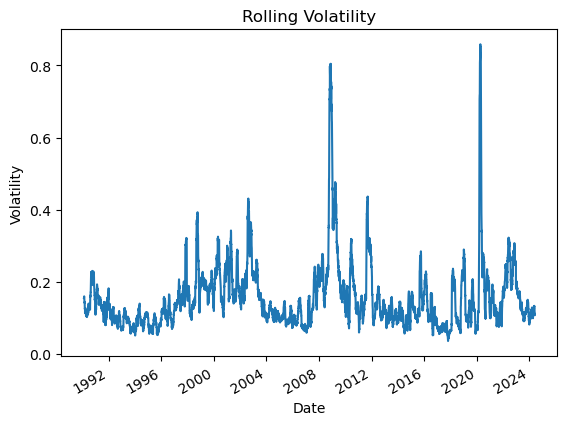

In [25]:
rolling_vol = asset_data['Log_Return'].rolling(window=30).std() * np.sqrt(252)
rolling_vol.plot()
plt.ylabel('Volatility')
plt.title('Rolling Volatility')
plt.show()

If volatility exceeds a threshold, tighten stop-losses.

# Significant Price Drops

In [19]:
# Create another function that detect the significant price drops
def detect_significant_price_drops(asset_data, threshold = 0.1):
    
    # NOTE: If threshold = 0.1, this means it is 10%
    
    #Identify significant price drops
    significant_price_drops = asset_data['Return'][asset_data['Return'] < -threshold]
    return significant_price_drops

In [20]:
threshold = 0.07
significant_price_drops = pd.DataFrame(detect_significant_price_drops(asset_data, threshold))

In [21]:
# Create a function to get the days between two dates
def get_date_diff(start_date, end_date):
    start_date = datetime.strptime(start_date, '%Y-%m-%d').date()
    end_date = datetime.strptime(end_date, '%Y-%m-%d').date()
    delta = end_date - start_date
    return delta.days

In [22]:
# Vectorized function to get the number of days between each price drop.
dates = significant_price_drops.index
significant_price_drops["Delta"]=[(None if i == -1 else (dates[i+1] - dates[i]).days) for i in range(-1,len(dates)-1)]

In [23]:
significant_price_drops

,Return,Delta
Date,,
2008-09-29,-0.088068,NaN
2008-10-09,-0.076167,10.0
2008-10-15,-0.090350,6.0
2008-12-01,-0.089295,47.0
2020-03-09,-0.075970,4116.0
2020-03-12,-0.095113,3.0
2020-03-16,-0.119841,4.0


In [24]:
#Get the average days of the significant drop and the average significant drop
average_drop = significant_price_drops.mean()
average_drop

Return     -0.090686
Delta     697.666667
dtype: float64

In [25]:
print('You can expect an average drop of', round(average_drop.iloc[0] * 100, 2), '% about every', \
      round(average_drop.iloc[1],0),'day(s), given the threshold',round(threshold*100,2),'%.')
print('This threshold was met', len(significant_price_drops), 'out of', len(asset_data), 'times.')
print('The biggest drop was', round(significant_price_drops['Return'].min()*100,2),'%.')

You can expect an average drop of -9.07 % about every 698.0 day(s), given the threshold 7.0 %.
This threshold was met 7 out of 8670 times.
The biggest drop was -11.98 %.


# Drawdown

In [5]:
def Drawdown (asset_data):
    asset_data['Drawdown'] = asset_data['Adj Close'] / asset_data['Adj Close'].cummax() - 1
    
    # return (asset_data['Adj Close'] / asset_data['Adj Close'].expanding(min_periods=1).max() - 1)

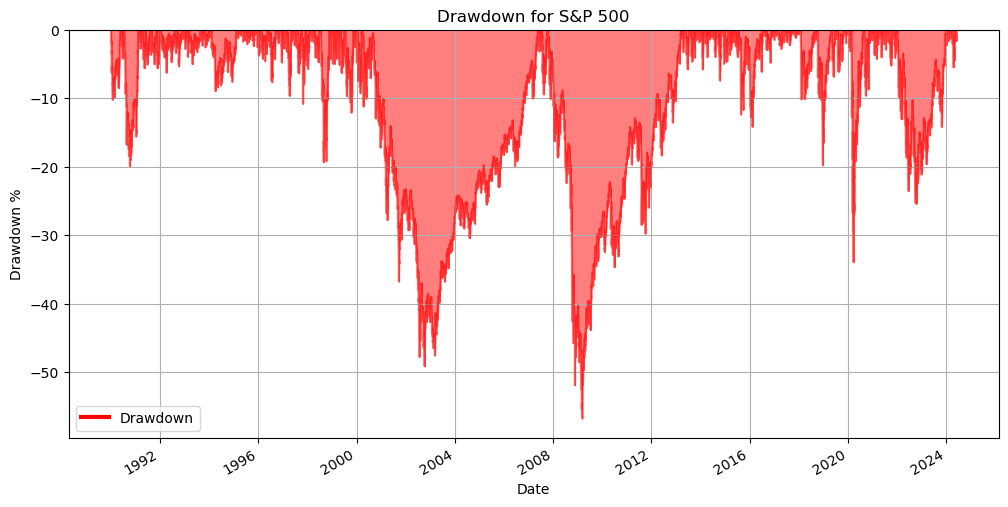

In [116]:
Drawdown(asset_data)

plt.figure(figsize=(12, 6))
(100*asset_data['Drawdown']).plot(kind='area', color='red', alpha=0.5)
plt.title('Drawdown for {}'.format(ticker.info['shortName']))
plt.xlabel('Date')
plt.ylabel('Drawdown %')
plt.grid()

# Customize the legend
lines = [
    plt.Line2D([0], [0], color='red', lw=3),
]
plt.legend(lines, ['Drawdown'], loc='lower left')

plt.show()

In [117]:
def duration(px):
    
    peak = px.expanding(min_periods=1).max()
    res = pd.Series(index=px.index,name=px.name)
    
    for dt in px.index:
        
        if px.loc[dt] >= peak.loc[dt]:
             res.loc[dt] = 0

        else:    
            res.loc[dt] = res.loc[:dt].iloc[-2] + 1

    return res

<Axes: xlabel='Date'>

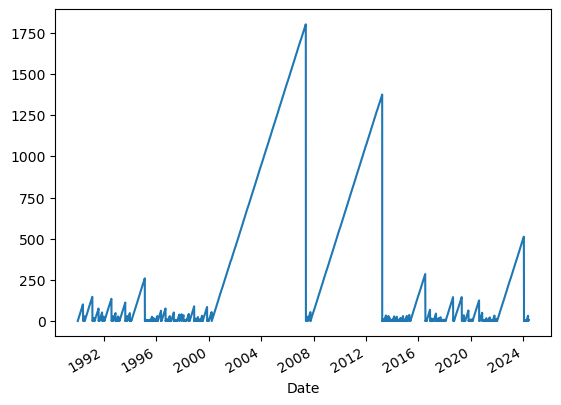

In [118]:
duration = duration(asset_data['Adj Close'])
duration.plot()

## Maximum Drawdown Size and Duration

In [123]:
# Calculate the maximum drawdown size
max_drawdown = asset_data['Drawdown'].min()

print(f"Maximum Drawdown: {max_drawdown * 100:.2f}%")
print(f"The Max Drawdown duration is {duration.max()} days: from",
      f"{duration[:duration.idxmax()][duration==0].last_valid_index().date()} till", 
      f"{duration.idxmax().date()}.")

Maximum Drawdown: -56.78%
The Max Drawdown duration is 1802.0 days: from 2000-03-24 till 2007-05-29.


## PDF of returns

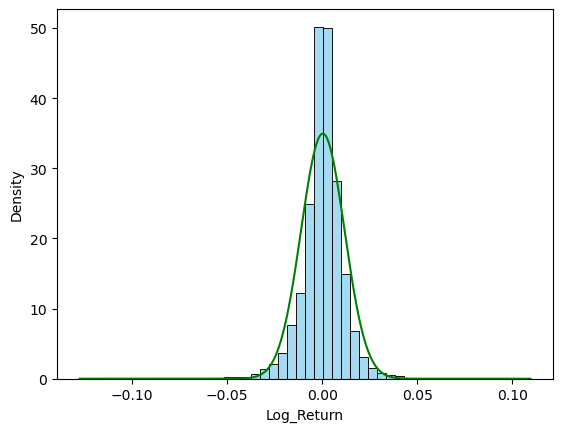

In [10]:
xs = np.linspace(asset_data['Log_Return'].min(), asset_data['Log_Return'].max(), len(asset_data['Log_Return']))
sns.histplot(asset_data['Log_Return'], stat='density', bins=50, color='skyblue')
plt.plot(xs, stats.norm.pdf(xs, asset_data['Log_Return'].mean(), asset_data['Log_Return'].std()), color='green')

## CDF of Returns Plot

Probability of a random return of our portfolio being smaller than or equal to r. P(R<=r)

In [47]:
unique_returns, counts = np.unique(asset_data['Return'].dropna(), return_counts=True)
cum_probs = np.cumsum(counts) / asset_data['Return'].count()

In [48]:
def plot_return_cdf(unique_returns, cum_probs):

    # Plot the CDF
    plt.figure(figsize=(8, 5))
    plt.plot(unique_returns, cum_probs, color='grey')
    plt.axvline(0, color='blue', linestyle='--')
    plt.fill_between(unique_returns, cum_probs, where=unique_returns < 0, color='red', alpha=0.5)
    plt.fill_between(unique_returns, cum_probs, 1, where=unique_returns >= 0, color='green', alpha=0.5)
    plt.xlabel('Returns')
    plt.ylabel('Cumulative Probability')
    plt.title('Cumulative Distribution of Returns')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

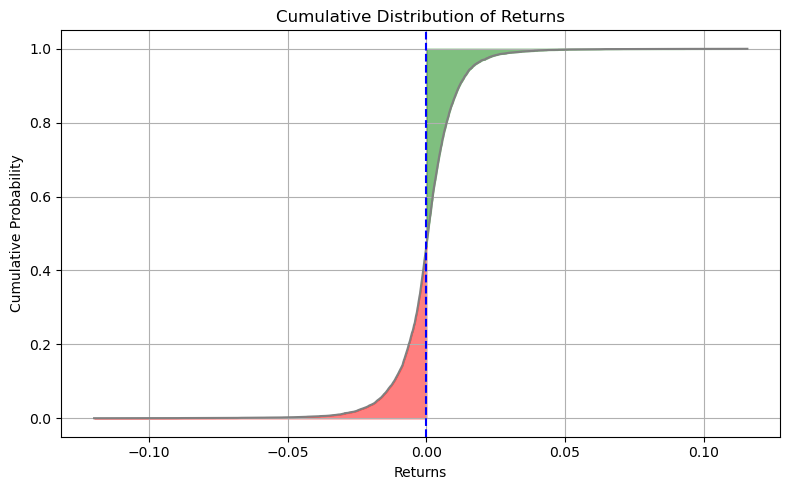

In [49]:
plot_return_cdf(unique_returns, cum_probs)

## Omega Ratio

In [50]:
def calculate_omega_ratio(unique_returns, cum_probs, threshold=0):
    # Find indices where returns are above and below threshold
    above_thresh = unique_returns > threshold
    below_thresh = unique_returns <= threshold
    
    # Calculate probabilities of gains and losses
    # We need 1-CDF for gains (probability of exceeding)
    gains = sum((1 - cum_probs[:-1][above_thresh[:-1]]) * 
                (unique_returns[1:][above_thresh[:-1]] - unique_returns[:-1][above_thresh[:-1]]))
    
    # We use CDF for losses
    losses = sum(cum_probs[:-1][below_thresh[:-1]] * 
                (unique_returns[1:][below_thresh[:-1]] - unique_returns[:-1][below_thresh[:-1]]))
    
    # Calculate Omega ratio
    omega = gains / abs(losses) if losses != 0 else float('inf')
    
    return omega

In [69]:
print(f"The omega ratio is {round(calculate_omega_ratio(unique_returns, cum_probs, threshold=0),3)} .")

The omega ratio is 1.102 .


## Value at Risk (VaR) & Conditional (CVAR)

Given a confidence parameter alpha, VaR is defined as the biggest lost we expect to see with 1-alpha % (confidence level) certainty.
Conversely, there’s a alpha% chance the losses will exceed this value. VaR gives you the "threshold" return (or loss).

The CVaR (also known as Expected Shortfall) is the average of losses that exceed the VaR threshold.

In [66]:
def var_cvar(returns, unique_returns, cum_probs, alpha=0.05):
    idx = np.argmax(cum_probs >= alpha)
    
    print(f"There's a {(1-alpha)*100}% chance the portfolio will not lose more than {round(unique_returns[idx]*100,3)}%.") 

    worse_returns = returns[returns <= unique_returns[idx]] 

    print(f"In the worst {(alpha)*100}% of scenarios, the average loss CVAR is {round(np.mean(worse_returns)*100,3)}%.") 

In [67]:
var_cvar(asset_data['Return'].dropna(), unique_returns, cum_probs, alpha=0.01) 

There's a 99.0% chance the portfolio will not lose more than -3.176%.
In the worst 1.0% of scenarios, the average loss CVAR is -4.57%.


# Extreme Value Theory (EVT) analysis for tail behavior

Pickands–Balkema–de Haan theorem, which states that exceedances over a high threshold approximately follow a Generalized Pareto Distribution (GPD).

CDF of the GPD: $H_{\xi,\beta}(x) = 
\begin{cases} 
1 - \left(1 + \frac{\xi x}{\beta}\right)^{-\frac{1}{\xi}}, & \text{if } \xi \neq 0, \\
1 - \exp\left(-\frac{x}{\beta}\right), & \text{if } \xi = 0.
\end{cases}$

𝜉: Shape parameter.\
𝛽: Scale parameter (𝛽>0 and measures the spread of the tail distribution).\
𝑥: The value of the random variable (𝑥≥0 for the GPD).

**Interpretation**:

𝜉>0: Heavy-tailed distribution.\
𝜉=0: Exponential distribution (special case).\
𝜉<0: Short-tailed distribution.

For 𝜉>0, returns have quite heavy tails, meaning extreme events are more likely than a normal distribution would predict.

Small 𝛽 value (0.010) indicates the exceedances are relatively concentrated.

In [8]:
def analyze_tail_behavior(returns: np.ndarray, 
                         threshold: float = 0.05,
                         bootstrap_samples: int = 100):
    """
    bootstrap_samples : int
        Number of bootstrap iterations for confidence intervals
    """

    # Filter exceedances
    threshold_value = np.quantile(returns, threshold)
    excess = returns[returns < threshold_value]
    
    gpd_params = stats.genpareto.fit(excess)
    
    # Extract parameters
    ξ = gpd_params[0]  # shape parameter (tail index)
    β = gpd_params[2]  # scale parameter
    
    # Bootstrap for confidence intervals
    tail_indices = np.zeros(bootstrap_samples)
    vars_99 = np.zeros(bootstrap_samples)
    
    for i in range(bootstrap_samples):
        boot_sample = np.random.choice(excess, size=len(excess), replace=True)
        boot_params = stats.genpareto.fit(boot_sample)
        tail_indices[i] = boot_params[0]
        vars_99[i] = stats.genpareto.ppf(0.99, *boot_params)
    
    # Calculate risk measures
    var_99 = stats.genpareto.ppf(0.99, *gpd_params)
    es_99 = var_99 / (1 - ξ) if ξ < 1 else np.inf
    
    return {
        'tail_index': ξ,
        'tail_index_ci': np.percentile(tail_indices, [2.5, 97.5]),
        'scale': β,
        'var_99': var_99,
        'var_99_ci': np.percentile(vars_99, [2.5, 97.5]),
        'expected_shortfall_99': es_99,
        'n_exceedances': len(excess),
        'threshold_value': threshold_value
    }

In [9]:
analyze_tail_behavior(asset_data['Log_Return'])

{'tail_index': -1.940104315950932,
 'tail_index_ci': array([-4.38205886,  1.17132226]),
 'scale': 0.23172724190375307,
 'var_99': -0.017451293122439454,
 'var_99_ci': array([-1.75625245e-02,  2.13146620e+01]),
 'expected_shortfall_99': -0.005935603382424579,
 'n_exceedances': 434,
 'threshold_value': -0.017432660950594772}